# Step 1 : We download the dataset from the server and store it in two different directores

In [ ]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip


--2020-10-23 10:46:20--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip.1’

cell_images.zip.1   100%[===================>] 337.08M  33.6MB/s    in 11s     

2020-10-23 10:46:31 (31.5 MB/s) - ‘cell_images.zip.1’ saved [353452851/353452851]



In [ ]:
!unzip cell_images.zip

Archive:  cell_images.zip
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Keras Utils for image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn Utils for Machine Learning Models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN 


# Metrics to access Performance
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 


# Numpy for matrix algebra
import numpy as np

# Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()



from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Step 2 : Preprocessing the Dataset

- Here, we the ImageDataGenerator functionality from keras to create a tensore-dataset of all the images along with predictions. 
- Since the 'Parasitized' Directory occurs first, it is alloted the label '0' while Uninfected images are allotted the label'1'

In [ ]:
data_directory = '/content/cell_images'
image_width = 32
image_height = 32
m = 27558
datagen = ImageDataGenerator(rescale=1/255)  #rescale all pixel values between [-1,1]

In [ ]:
data_generator = datagen.flow_from_directory(directory=data_directory, target_size=(image_width,image_height),
                                                   class_mode = 'binary', batch_size = m, shuffle=True, subset='training'
                                                   )


Found 27558 images belonging to 2 classes.


Now we obtain the Image Tesnor from the Datagenerator object and extract the Tensor containing data as 'X'. We reshape it to suitable for training on Machine learning algorithms. 

In [ ]:
x_data = data_generator[0][0]
print(x_data.shape)  #expect (27558,32,32,3)
x_data = x_data.reshape(x_data.shape[0],x_data.shape[1]*x_data.shape[2]*x_data.shape[3])
print(x_data.shape)  #expect (27558,3072)

(27558, 32, 32, 3)
(27558, 3072)


Similarly we apply a similar transformation for the labels 'Y'

In [ ]:
y_data = data_generator[0][1]
print(y_data.shape)

(27558,)


In [ ]:
# We only use 5000 Images for training and testing ; otherwise the training tends to be too slow 
x_data = x_data[:5000,:]
y_data = y_data[:5000]

# Step 3 : Training the Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)


In [ ]:
print(len(X_train),len(X_test))

4000 1000


## Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=0,max_iter=5000)
logreg.fit(X_train, y_train)
logreg_probs = logreg.predict_proba(X_test)

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators =500,criterion='entropy', random_state=50)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)

## Support Vector Machine

## K- Nearest Neighbour Classifier

In [ ]:
knn = KNN(n_neighbors = 2) 
knn.fit(X_train, y_train)
knn_probs = knn.predict_proba(X_test)

## Naive Bayes Classification


In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)
nb_probs = nb.predict_proba(X_test)

# Step 4 : Computing AUC and ROC values

In [ ]:
# Storing the probabilities for positive outcome 

prob_vals = [logreg_probs,rf_probs, knn_probs,nb_probs]
r_probs = [0 for _ in range(len(y_test))]  # worst case probability

positive_prob_vals = [i[:,1] for i in prob_vals]

p_logreg_probs,p_rf_probs, p_knn_probs,p_nb_probs = positive_prob_vals

In [ ]:
## Computing ROC and AUC values

r_auc = roc_auc_score(y_test,r_probs)
log_reg_auc = roc_auc_score(y_test,p_logreg_probs)
rf_auc = roc_auc_score(y_test,p_rf_probs)
knn_auc = roc_auc_score(y_test,p_knn_probs)
nb_auc = roc_auc_score(y_test,p_nb_probs)

In [ ]:
## Print AUROC scores

print("Random (chance) Prediction : AUROC = %.3f" %(r_auc))
print('Logistic Regression : AUROC = %.3f' %(log_reg_auc))
print('Random Forest : AUROC = %.3f' %(rf_auc))
print('KNN : AUROC = %.3f' %(knn_auc))
print('Naive Bayes : AUROC = %.3f' %(nb_auc))


Random (chance) Prediction : AUROC = 0.500
Logistic Regression : AUROC = 0.730
Random Forest : AUROC = 0.850
KNN : AUROC = 0.622
Naive Bayes : AUROC = 0.622


In [ ]:
## Calculate ROC curve

r_fpr, r_tpr , _ = roc_curve(y_test, r_probs)
logreg_fpr,logreg_tpr, _ = roc_curve(y_test, p_logreg_probs)
rf_fpr,rf_tpr, _ = roc_curve(y_test, p_rf_probs)
knn_fpr,knn_tpr, _ = roc_curve(y_test, p_knn_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, p_nb_probs) 

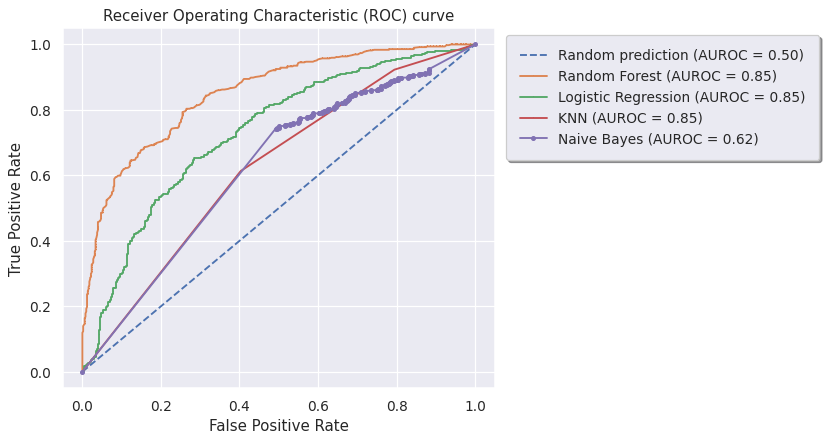

In [ ]:

### Plot the ROC curves

fig = plt.figure(num=1,dpi=90,figsize=(6,5))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.plot(r_fpr,r_tpr, ls = '--', label='Random prediction (AUROC = %0.2f)' %(r_auc))

axes.plot(rf_fpr,rf_tpr, marker = ',', label='Random Forest (AUROC = %0.2f)' %(rf_auc))
axes.plot(logreg_fpr,logreg_tpr, marker = ',', label='Logistic Regression (AUROC = %0.2f)' %(rf_auc))
axes.plot(knn_fpr,knn_tpr, marker = ',', label='KNN (AUROC = %0.2f)' %(rf_auc))
axes.plot(nb_fpr,nb_tpr, marker = '.', label='Naive Bayes (AUROC = %0.2f)' %(nb_auc))

axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('Receiver Operating Characteristic (ROC) curve') 

axes.legend(bbox_to_anchor=(1.01, 1),fancybox=True, framealpha=1, shadow=True, borderpad=1)

plt.show()



## ROC curve

The **Receiver Operating Characteristic** (ROC) curve summarises the prediction performance of a classification model at all classification thresholds. Particularly, the ROC curve plots the **False Positive Rate** (FPR) on the X-axis and the **True Positive Rate** (TPR) on the Y-axis. 

TPR (Sensitivity) = TP / (TP + FN)

FPR (1 - Specificity) = FP/ (TN + FP)


In [ ]:
from sklearn.externals import joblib

joblib.dump(knn, '/content/drive/My Drive/DS-Python-notebooks/My-Projects/Malaria/knn_acc_63.pkl')

['/content/drive/My Drive/DS-Python-notebooks/My-Projects/Malaria/knn_acc_63.pkl']